# Configurable arbitrage and slippage in automated market making systems


Scott Condie
ssc@byu.edu

Description: Analysis for the paper "Configurable arbitrage and slippage in automated market making systems".

In [71]:
from pprint import pprint
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from functools import partial
import matplotlib as mpl
import matplotlib.dates as mdates
from cycler import cycler
import pandas as pd

major_tick_color = "black"
minor_tick_color = "darkslategray"
color_list = ['steelblue', 'teal','indianred', 'darkslategray']

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['axes.prop_cycle'] = cycler(color=color_list)
mpl.rc('text.latex', preamble=r'\usepackage{cmbright}')

def plot_lines(list_of_dicts_of_data, save_file_name, save=True, show=True, legend=True):
    fig, ax = plt.subplots()
    for ii in list_of_dicts_of_data:
        ax.plot(ii['data'], label=ii['label'])
    if legend:   
        plt.legend(frameon=False, loc=0)
    plt.grid(visible=True, color=major_tick_color, which="major", alpha=0.8, linestyle=":", linewidth=0.5)
    plt.minorticks_on()
    plt.grid(visible=True, color=minor_tick_color, which="minor", alpha=0.5, linestyle=":", linewidth=0.3)
    if save:
        plt.savefig(save_file_name)
    if show:
        plt.show()
    return fig, ax

## Parameters

In [72]:
# This implies a price of 1. 
K = 10
x = 100
y = 100
sigma = 2
n = 200

# Distribution for epsilonx, epsilony, and v
# Noisy demand is expected to be 0 with a variance of 10 percent of liquidity.
Feps = stats.norm
eps_mean = 0
eps_var = 10
Fv = stats.norm

# Random draw of changes to the pool of x and y

delta_x = default_rng().normal(loc=0, scale=sigma,size=n)
delta_y = default_rng().normal(loc=0, scale=sigma,size=n)
# Quantities of x and y


x_vec = np.zeros(n)
y_vec = np.zeros(n)
x_vec[0] = x
y_vec[0] = y
for ii in range(x_vec.size)[1:]:
    x_vec[ii] = x_vec[ii-1] + delta_x[ii]
    y_vec[ii] = y_vec[ii-1] + delta_y[ii]


In [73]:
def cp_price(y,x):
    return y/x

def cp_price_impact(y,x):
    return 1/x

def ce_price(y,x,alpha,theta):
    return (alpha/(1-alpha))*(x/y)**theta

def ce_price_impact(y,x,alpha,theta):
    return -(theta/x)
    
def oracle_alpha(p,x,y,theta):
    return p/(p + (x/y)**theta)
    

## Plot price as a function of quantity

In [74]:
alpha = 0.5
theta5 = -0.5
theta2 = -2
x = 100
y = 100
k_ce5 = (alpha*x**(1+theta5) + (1-alpha)*y**(1+theta5))**(1/(1+theta5))
k_ce2 = (alpha*x**(1+theta2) + (1-alpha)*y**(1+theta2))**(1/(1+theta2))
k_cp = x*y

def ce_price_large(y,x,alpha,theta, deltax, k):
    return ((k**(1+theta) - alpha*(x - deltax)**(1+theta))/(1-alpha))**(1/(1+theta)) - y 

def cp_price_large(y, x, deltax, k):
    return k/(x - deltax) - y
    
    
dx = np.linspace(0,20,100)
ce_p5 = [ ce_price_large(y,x,alpha,theta5,ddx,k_ce5) for ddx in dx]
ce_p2 = [ ce_price_large(y,x,alpha,theta2,ddx,k_ce2) for ddx in dx]
cp_p = [ cp_price_large(y,x,ddx,k_cp ) for ddx in dx] 

plot_data = [{'data': ce_p5, 'label': r"CE ($\theta = -\frac{1}{2}$)"},
             {'data': ce_p2, 'label': r"CE ($\theta = -2$)"},
             {'data': cp_p, 'label': r"CP"}]
             
#fig, ax = plot_lines(plot_data, "price_functions.jpg", show=False, save=False)

fig, ax = plt.subplots()
for ii in plot_data:
    ax.plot(dx, ii['data'], label=ii['label'])
  
plt.legend(frameon=False, loc=0)
plt.grid(visible=True, color=major_tick_color, which="major", alpha=0.8, linestyle=":", linewidth=0.5)
plt.minorticks_on()
plt.grid(visible=True, color=minor_tick_color, which="minor", alpha=0.5, linestyle=":", linewidth=0.3)
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$\Delta y$")

plt.savefig("price_functions.jpg")
plt.savefig("price_functions.pdf")
plt.show()


In [75]:
# Calculate price and price impact

cp_realized_price = np.zeros(n)
cp_realized_price_impact = np.zeros(n)

#ce_realized_price = np.zeros(n)
#ce_realized_price_impact = np.zeros(n)

ce_realized_price_0_5 = np.zeros(n)
ce_realized_price_impact_0_5 = np.zeros(n)

ce_realized_price_2 = np.zeros(n)
ce_realized_price_impact_2 = np.zeros(n)

ce_realized_price_5 = np.zeros(n)
ce_realized_price_impact_5 = np.zeros(n)

alpha = 1./2
theta = -0.5

for ii in range(n):
    cp_realized_price[ii] = cp_price(y_vec[ii], x_vec[ii])
    cp_realized_price_impact[ii] = cp_price_impact(y_vec[ii], x_vec[ii])
    ce_realized_price_0_5[ii] = ce_price(y_vec[ii], x_vec[ii], alpha, -0.5)
    ce_realized_price_impact_0_5[ii] = ce_price_impact(y_vec[ii], x_vec[ii], alpha, -0.5)
    ce_realized_price_2[ii] = ce_price(y_vec[ii], x_vec[ii], alpha, -2)
    ce_realized_price_impact_2[ii] = ce_price_impact(y_vec[ii], x_vec[ii], alpha, -2)
    ce_realized_price_5[ii] = ce_price(y_vec[ii], x_vec[ii], alpha, -5)
    ce_realized_price_impact_5[ii] = ce_price_impact(y_vec[ii], x_vec[ii], alpha, -5)


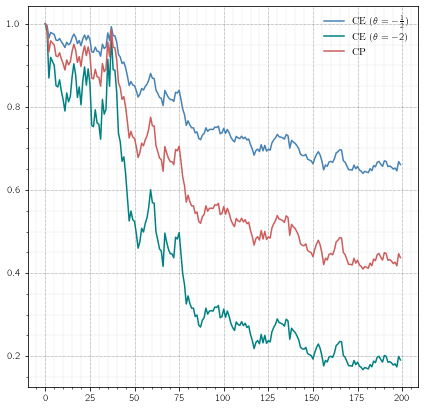

(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

In [76]:
# Plot the price of each pricing function

plot_data = [{'data': ce_realized_price_0_5, 'label':r"CE ($\theta = -\frac{1}{2}$)" },
             {'data': ce_realized_price_2, 'label': r"CE ($\theta = -2$)"},
             {'data': cp_realized_price, 'label': 'CP'}]

save_file = "price_sim.jpg"

plot_lines(plot_data, save_file)
plot_lines(plot_data, 'price_sim.pdf')


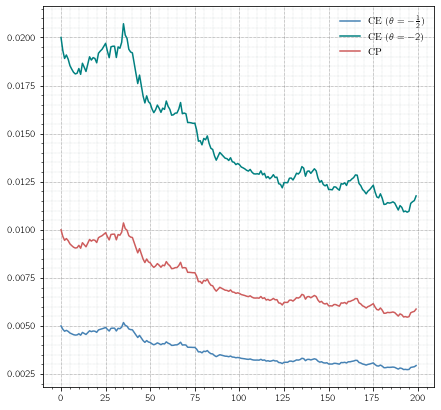

(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

In [77]:
# Plot the price impact of each pricing function

plot_data = [{'data': ce_realized_price_impact_0_5, 'label':r"CE ($\theta = -\frac{1}{2}$)" },
             {'data': ce_realized_price_impact_2, 'label': r"CE ($\theta = -2$)"},
             {'data': cp_realized_price_impact, 'label': 'CP'}]

save_file = "price_impact_sim.jpg"
plot_lines(plot_data, save_file)
plot_lines(plot_data, "price_impact_sim.pdf")

## Build arbitrage-free prices from a cp market as oracle

In [78]:
implied_alpha = np.zeros(n)
arb_free_ce_price = np.zeros(n)
arb_free_ce_price_impact = np.zeros(n)

theta = -0.5

for ii in range(n):
    imp_alpha = oracle_alpha(cp_realized_price[ii], x_vec[ii], y_vec[ii], theta)
    implied_alpha[ii] = imp_alpha
    arb_free_ce_price[ii] = ce_price(y_vec[ii], x_vec[ii], imp_alpha, theta )
    arb_free_ce_price_impact[ii] = ce_price_impact(y_vec[ii], x_vec[ii], imp_alpha, theta)

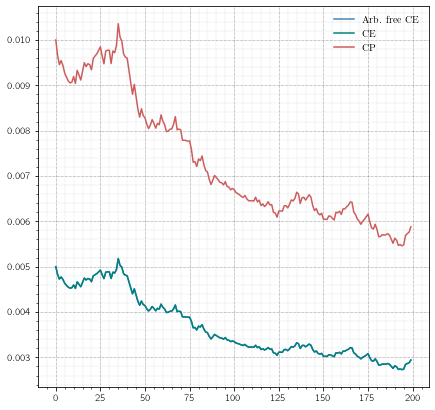

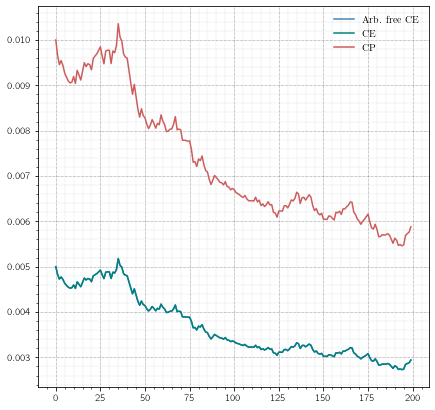

(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

In [79]:
# Plot the arb_free_price_impact against the CP price impact for the same market conditions
plot_data = [{'data': arb_free_ce_price_impact, 'label': 'Arb. free CE'},
             {'data': ce_realized_price_impact_0_5, 'label': 'CE'},
             {'data': cp_realized_price_impact, 'label': 'CP'}]

save_file = "arb_free_pi.jpg"

plot_lines(plot_data, save_file)
plot_lines(plot_data, "arb_free_pi.pdf")


## Use real data

In [80]:
data = pd.read_csv("LOBPriceOneDayBTCBUST.csv")
data['date_time'] = pd.to_datetime(data['date_time'])
data['day'] = data['date_time'].dt.day
data = data[data['day']==9]


data['midpoint'] = data['best_bid'] + (data['best_ask'] - data['best_bid'])/2
mp = data['midpoint']
n = mp.shape[0]
theta_0_5 = -0.8
theta_2 = -1.2
alpha = 0.5

pprint(mp.head(100))



## PLOT THE VOLUME OF TRADE THAT WOULD NEED TO HAPPEN IF PRICES WERE TO STAY EQUAL TO THE ORACLE PRICE.
## THIS ASSUMES THAT TRADE HAPPENS BY BUYING AND SELLING GOOD X IN A SINGLE TRANSACTION

p_init = mp.iloc[0]
x_vec_ce_0_5 = np.zeros(n)
y_vec_ce_0_5 = np.zeros(n)
x_vec_ce_2 = np.zeros(n)
y_vec_ce_2 = np.zeros(n)
x_vec_cp = np.zeros(n)
y_vec_cp = np.zeros(n)

# Define initial values for the x and y quantities for CE -0.5
x_vec_ce_0_5[0] = 10000   # Start with this much liquidity in x, by assumption
y_vec_ce_0_5[0] = x_vec_ce_0_5[0]/(((1-alpha)/alpha)*p_init)**(1/theta_0_5)
k_ce_0_5 = (alpha*x_vec_ce_0_5[0]**(1+theta_0_5) + (1-alpha)*y_vec_ce_0_5[0]**(1+theta_0_5))**(1/(1+theta_0_5))

# Define initial values for the x and y quantities for CE -2
x_vec_ce_2[0] = 10000   # Start with this much liquidity in x, by assumption
y_vec_ce_2[0] = x_vec_ce_2[0]/(((1-alpha)/alpha)*p_init)**(1/theta_2)
k_ce_2 = (alpha*x_vec_ce_2[0]**(1+theta_2) + (1-alpha)*y_vec_ce_2[0]**(1+theta_2))**(1/(1+theta_2))


# Define initial values for the x and y quantities for CP
x_vec_cp[0] = 10000
y_vec_cp[0] = p_init*10000
k_cp = x_vec_cp[0]*y_vec_cp[0]


def implied_quantities_ce(p,x,y,alpha,theta, k):
    rat = (((1-alpha)/alpha)*p)**(1/theta)
    z = rat/(x/y)          # How much larger is rat than x/y      
    new_x = (rat*k)/((1-alpha + alpha*rat**(1+theta)))**(1/(1+theta))
    new_y = new_x/rat
    return [new_x,new_y]

def implied_quantities_cp(p,x,y, k):
    rat = p 
    new_x = (k_cp/rat)**0.5
    new_y = k/new_x
    return [new_x, new_y]
        
        
for ii in range(1, n):
    q_ce_0_5 = implied_quantities_ce(mp.iloc[ii], x_vec_ce_0_5[ii-1], y_vec_ce_0_5[ii-1], alpha, theta_0_5, k_ce_0_5)
    x_vec_ce_0_5[ii] = q_ce_0_5[0]
    y_vec_ce_0_5[ii] = q_ce_0_5[1]
    q_ce_2 = implied_quantities_ce(mp.iloc[ii], x_vec_ce_2[ii-1], y_vec_ce_2[ii-1], alpha, theta_2, k_ce_2)
    x_vec_ce_2[ii] = q_ce_2[0]
    y_vec_ce_2[ii] = q_ce_2[1]
    q_cp = implied_quantities_cp(mp.iloc[ii], x_vec_cp[ii-1], y_vec_cp[ii-1], k_cp)
    x_vec_cp[ii] = q_cp[0]
    y_vec_cp[ii] = q_cp[1]

    
   
plot_data = [{'data': x_vec_ce_0_5, 'label': r"CE ($\theta = -\frac{4}{5}$)"},
             {'data': x_vec_ce_2, 'label': r"CE ($\theta = -\frac{6}{5}$)"},
             {'data': x_vec_cp, 'label': r"CP"}]

#fig, ax = plot_lines(plot_data, "x_quantities.jpg", save=True, show=False, legend=False)



fig, ax = plt.subplots()
pprint(data['date_time'].shape)
pprint(x_vec_ce_0_5.shape)

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

for ii in plot_data:
    ax.plot(data['date_time'], ii['data'], label=ii['label'])
 


plt.grid(visible=True, color=major_tick_color, which="major", alpha=0.8, linestyle=":", linewidth=0.5)
plt.minorticks_on()
plt.grid(visible=True, color=minor_tick_color, which="minor", alpha=0.5, linestyle=":", linewidth=0.3)

plt.xticks(rotation=50)

lns = ax.get_lines()

ax2 = ax.twinx()
ax2.xaxis.set_major_locator(mdates.HourLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

ticks = [ tt for tt in range(n) if n % 100 == 0]
tick_labels = [ data['date_time'][tt] for tt in range(n) if n %100 == 0]

ln = ax2.plot(data['date_time'], mp, color="silver", label=r"$p_{o}$")
lns.extend(ln)
lbls = [ll.get_label() for ll in lns]
ax.legend(lns, lbls, loc="center left", frameon=False)
#plt.xticks(ticks, tick_labels)

ax2.set_ylabel("BTCUSDT price (Binance)", color="silver")
ax.set_ylabel("Required BTC liquidity")
plt.xlim([data['date_time'].iloc[0], data['date_time'].iloc[-1]])
plt.savefig('x-quantities.jpg')
plt.savefig('x-quantities.pdf')
plt.show()

101    41624.265
102    41606.645
103    41588.565
104    41575.005
105    41581.265
         ...    
196    41610.965
197    41611.385
198    41616.425
199    41617.805
200    41626.645
Name: midpoint, Length: 100, dtype: float64
(11841,)
(11841,)


## Matching both price and slippage.

First, collect the data that we need which are the best bids and asks and the slippage on the bid and ask side.

In [81]:
deltax = 2                # The number of units around which slippage should be calculated.
import json
import ast

y = ast.literal_eval(data['bids'].head(10)[101])


def get_bid_slippage(deltax, bids):
    first_price = float(bids[0][0])
    q = 0
    current_price = first_price
    for bb in bids:
        current_price = float(bb[0])
        q = q + float(bb[1])
        if q > deltax:
            break
        
    return np.abs(current_price/first_price - 1)
        
    
def get_ask_slippage(deltax, asks):
    first_price = float(asks[0][0])
    q = 0
    current_price = first_price
    for aa in asks:
        current_price = float(aa[0])
        q = q + float(aa[1])
        if q > deltax:
            break
    
    return np.abs(current_price/first_price - 1)


asks = []
bids = []
ask_s = []
bid_s = []
for idx, dd in data.iterrows():
    a = ast.literal_eval(dd['asks'])
    b = ast.literal_eval(dd['bids'])
    asks.append(float(a[0][0]))
    ask_s.append(get_ask_slippage(deltax, a))
    bids.append(float(b[0][0]))
    bid_s.append(get_bid_slippage(deltax, b))
    


## Solve for both $\alpha$ and $\theta$ simultaneously using price sensitivity as an approximation of slippage

In [82]:
from scipy.optimize import fsolve, fmin
from functools import partial

n = mp.shape[0]

p_init = mp.iloc[0]
x_vec = np.ones(n)
y_vec = np.ones(n)

alpha = 0.5
x_vec = 100*x_vec   # Have 100 by assumption
y_vec = 100*y_vec 



#      I am running into precision problems with the alphas because prices are so high.
#      To get around this, I am going to divide all prices by 1000, so the price of bitcoin is
#      about $42.

mp = mp/1000.
print(mp.head(10))

theta = [ ]
def arb_alpha(theta, p0, x=100, y=100):
    return p0/(p0 + (x/y)**theta)

def arb_theta(s0, deltax, x0):
    return -x*s0/deltax

def price(x,y,alpha,theta):
    alpha = np.longdouble(alpha)
    theta = np.longdouble(theta)
    out = (alpha/(1-alpha))*(float(x)/float(y))**theta
    return out

def get_bid_slippage(deltax, bids):
    first_price = float(bids[0][0])
    q = 0
    current_price = first_price
    for bb in bids:
        current_price = float(bb[0])
        q = q + float(bb[1])
        if q > deltax:
            break
        
    return np.abs(current_price/first_price - 1)
        
    
def get_ask_slippage(deltax, asks):
    first_price = float(asks[0][0])
    q = 0
    current_price = first_price
    for aa in asks:
        current_price = float(aa[0])
        q = q + float(aa[1])
        if q > deltax:
            break
    
    return np.abs(current_price/first_price - 1)

deltax = 1
alphas = np.zeros(n)
thetas = np.zeros(n)
slippage = np.zeros(n)
imp_price = np.zeros(n)


for idx in range(n):
    # theta=-0.5
    x = x_vec[idx]
    y = y_vec[idx]
    bids = ast.literal_eval(data.iloc[idx]['bids'])    # This is written as a string (in list format)
    asks = ast.literal_eval(data.iloc[idx]['asks'])    # This is written as a string (in list format)
    bid_s = get_bid_slippage(deltax, bids)
    ask_s = get_ask_slippage(deltax, asks)
    p = mp.iloc[idx]
    s = 0.5*(bid_s + ask_s)
    th = arb_theta(s,deltax, x)
    thetas[idx] = th
    alphas[idx] = arb_alpha(th, p, x, y)
    slippage[idx] = s
    
    imp_price[idx] = price(x,y,alphas[idx], thetas[idx])

print(imp_price)

101    41.624265
102    41.606645
103    41.588565
104    41.575005
105    41.581265
106    41.588325
107    41.581275
108    41.566925
109    41.568145
110    41.555555
Name: midpoint, dtype: float64
[41.624265 41.606645 41.588565 ... 39.270005 39.282265 39.298775]


# Plot the $\alpha$s and $\theta$s against the price and slippage

(11841,)
(11841,)
(11841,)


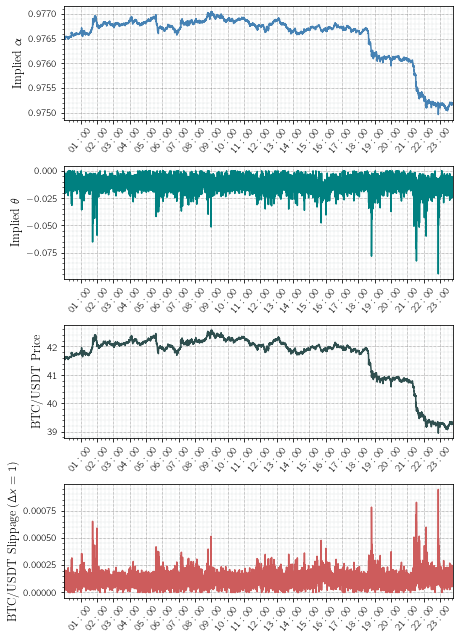

'\nlns = ax.get_lines()\n\nax2 = ax.twinx()\n\nticks = [ tt for tt in range(n) if n % 100 == 0]\ntick_labels = [ data[\'date_time\'][tt] for tt in range(n) if n %100 == 0]\n\nln = ax2.plot(data[\'date_time\'], mp, color="silver", label=r"$p_{o}$")\nlns.extend(ln)\nlbls = [ll.get_label() for ll in lns]\nax.legend(lns, lbls, loc="center left", frameon=False)\n#plt.xticks(ticks, tick_labels)\n\nax2.set_ylabel("BTCUSDT price (Binance)", color="silver")\nax.set_ylabel(r"Estimated $\x07lpha$ and $\theta$")\nplt.xlim([data[\'date_time\'].iloc[0], data[\'date_time\'].iloc[-1]])\nplt.savefig(\'x-quantities.jpg\')\nplt.show()\n'

In [83]:
plt.rcParams['figure.figsize'] = [6.5, 9]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
print(alphas.shape)
print(thetas.shape)
print(data['date_time'].shape)



fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)



ax1.xaxis.set_major_locator(mdates.HourLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.plot(data['date_time'], alphas, color="steelblue")
ax1.set_ylabel(r"Implied $\alpha$")
ax1.grid(visible=True, color=major_tick_color, which="major", alpha=0.8, linestyle=":", linewidth=0.5)
ax1.minorticks_on()
ax1.grid(visible=True, color=minor_tick_color, which="minor", alpha=0.5, linestyle=":", linewidth=0.3)
ax1.tick_params(axis="x", rotation=50)
ax1.set_xlim([data['date_time'].iloc[0], data['date_time'].iloc[-1]])


ax2.xaxis.set_major_locator(mdates.HourLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax2.plot(data['date_time'], thetas, color="teal")
ax2.set_ylabel(r"Implied $\theta$")
ax2.grid(visible=True, color=major_tick_color, which="major", alpha=0.8, linestyle=":", linewidth=0.5)
ax2.minorticks_on()
ax2.grid(visible=True, color=minor_tick_color, which="minor", alpha=0.5, linestyle=":", linewidth=0.3)
ax2.tick_params(axis="x", rotation=50)
ax2.set_xlim([data['date_time'].iloc[0], data['date_time'].iloc[-1]])


ax3.xaxis.set_major_locator(mdates.HourLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax3.plot(data['date_time'], mp, color="darkslategray")
ax3.set_ylabel(r"BTC/USDT Price")
ax3.grid(visible=True, color=major_tick_color, which="major", alpha=0.8, linestyle=":", linewidth=0.5)
ax3.minorticks_on()
ax3.grid(visible=True, color=minor_tick_color, which="minor", alpha=0.5, linestyle=":", linewidth=0.3)
ax3.tick_params(axis="x", rotation=50)
ax3.set_xlim([data['date_time'].iloc[0], data['date_time'].iloc[-1]])

ax4.xaxis.set_major_locator(mdates.HourLocator())
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax4.plot(data['date_time'], slippage, color="indianred")
ax4.set_ylabel(r"BTC/USDT Slippage ($\Delta x = 1$)")
ax4.grid(visible=True, color=major_tick_color, which="major", alpha=0.8, linestyle=":", linewidth=0.5)
ax4.minorticks_on()
ax4.grid(visible=True, color=minor_tick_color, which="minor", alpha=0.5, linestyle=":", linewidth=0.3)
ax4.tick_params(axis="x", rotation=50)
ax4.set_xlim([data['date_time'].iloc[0], data['date_time'].iloc[-1]])


plt.tight_layout()
plt.savefig("implied_params.jpg")
plt.savefig("implied_params.pdf")
plt.show()



"""
lns = ax.get_lines()

ax2 = ax.twinx()

ticks = [ tt for tt in range(n) if n % 100 == 0]
tick_labels = [ data['date_time'][tt] for tt in range(n) if n %100 == 0]

ln = ax2.plot(data['date_time'], mp, color="silver", label=r"$p_{o}$")
lns.extend(ln)
lbls = [ll.get_label() for ll in lns]
ax.legend(lns, lbls, loc="center left", frameon=False)
#plt.xticks(ticks, tick_labels)

ax2.set_ylabel("BTCUSDT price (Binance)", color="silver")
ax.set_ylabel(r"Estimated $\alpha$ and $\theta$")
plt.xlim([data['date_time'].iloc[0], data['date_time'].iloc[-1]])
plt.savefig('x-quantities.jpg')
plt.show()
"""

## Plot the actual price change in the AMM market for changes in liquidity purchases compared to the approximation

In [84]:
alpha = 0.5
theta5 = -0.5
theta2 = -2
x = 10
y = 10


def bbo(bids, asks):
    best_bid = np.longdouble(bids[0][0])/1000.
    best_ask = np.longdouble(asks[0][0])/1000.
    return [best_bid, best_ask] 

def get_bid_slippage(deltax, bids, asks):
    b_a = bbo(bids, asks)
    mp = (b_a[0] + b_a[1])*0.5
    #first_price = np.longdouble(bids[0][0])/1000.
    first_price = mp
    q = 0
    current_price = first_price
    for bb in bids:
        current_price = np.longdouble(bb[0])/1000.
        q = q + np.double(bb[1])
        if q > deltax:
            break
        
    return np.abs((current_price - first_price)/first_price)
        
def get_ask_slippage(deltax, bids, asks):
    b_a = bbo(bids, asks)
    mp = (b_a[0] + b_a[1])*0.5
    #first_price = np.longdouble(asks[0][0])/1000.
    first_price = mp    
    q = 0
    current_price = first_price
    for aa in asks:
        current_price = np.longdouble(aa[0])/1000.
        q = q + float(aa[1])
        if q > deltax:
            break
    
    return np.abs((current_price - first_price)/first_price)



def new_marg_price(dx, x, y, k, alpha, theta):
    # This calculates the new x and y if deltax is purchased and finds the marginal price with those new pool quantities
    numer = k**(1+theta) - alpha*(x-dx)**(1+theta)
    denom = 1-alpha
    frac = (numer/denom)**(1/(1+theta))
    new_y = frac
    new_x = x - dx
    new_price = (alpha/(1-alpha))*(new_x/new_y)**theta
    return new_price

# Use the original alphas and thetas to calculate k
k = (alphas[0]*x**(1+thetas[0]) + (1-alphas[0])*y**(1+thetas[0]))**(1/(1+thetas[0]))

deltax = 1

def slip_dx(deltax):
    alphas = np.zeros(n)
    thetas = np.zeros(n)
    slippage = np.zeros(n)
    new_prices = np.zeros(n)
    actual_slippage = np.zeros(n)
    for idx in range(n):
        k = 10000
        # theta=-0.5
        x = x_vec[idx]
        y = y_vec[idx]
        bids = ast.literal_eval(data.iloc[idx]['bids'])    # This is written as a string (in list format)
        asks = ast.literal_eval(data.iloc[idx]['asks'])    # This is written as a string (in list format)
        bid_s = get_bid_slippage(deltax, bids, asks)
        ask_s = get_ask_slippage(deltax, bids, asks)
        p = mp.iloc[idx]
        s = 0.5*(bid_s + ask_s)
        bid_ask = bbo(bids, asks)
        spread = bid_ask[1] - bid_ask[0] 
        s = 0.5*spread
        th = arb_theta(s, deltax, x)
        al = arb_alpha(th, p, x, y)
        thetas[idx] = th
        alphas[idx] = al
        slippage[idx] = s
        k = (al*x**(1+th) + (1-al)*y**(1+th))**(1/(1+th))
        imp_p = price(x, y, al, th)
        new_prices[idx] = new_marg_price(deltax, x, y, k, al, th)
        pct = (new_prices[idx] - imp_p)/imp_p
        #print(np.abs(pct-s))
        actual_slippage[idx] = pct
        
    return {'slippage_amm': actual_slippage, 'slippage_oracle': slippage}

d1 = slip_dx(1)

plt.plot(d1['slippage_oracle'][0:50], label="Oracle slippage")
plt.plot(d1['slippage_amm'][0:50], label="AMM slippage")
plt.legend()
#plt.plot(actual_slippage, label="AMM slippage")
plt.show()

## Plot the AMM slippage and orderbook slippage for one orderbook

In [221]:
# Choose an orderbook
ob =5008

plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['text.usetex'] = True
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['axes.prop_cycle'] = cycler(color=color_list)
mpl.rc('text.latex', preamble=r'\usepackage{cmbright}')

bids = ast.literal_eval(data.iloc[ob]['bids'])    # This is written as a string (in list format)
asks = ast.literal_eval(data.iloc[ob]['asks'])    # This is written as a string (in list format)

def amm_slippage(dx, x, y, k, alpha, theta):
    # Calculate the percent change in price from a removal of dx from the pool of x
    numer = k**(1+theta) - alpha*(x-dx)**(1+theta)
    denom = k**(1+theta) - alpha*x**(1+theta)
    dy_pct = (numer/denom)**(1/(1+theta))
    dx_pct = (x-dx)/x
    out = (dx_pct/dy_pct)**theta - 1
    return out

## Actual slippage
q = np.linspace(0.001, 5, 1000)
slippage_ob = []
for qq in q:
    a_s = get_ask_slippage(qq, bids, asks)
    slippage_ob.append(a_s)

    
    
# AMM slippage
slip_params = [6, 10, 17]
x=100
y=100
slippage_amm1 = []
approx_slip = []
sp = bbo(bids, asks)
midpoint = (sp[0] + sp[1])*0.5
th_param1 = slip_params[0]
th = arb_theta(slippage_ob[th_param1],q[th_param1],x)

print("Slippage calibrated point: {}".format(q[th_param1]))
print("Time of day: {}".format(data.iloc[ob]['date_time']))
al = arb_alpha(th, midpoint, x=x, y=y)
k = (al*x**(1+th) + (1-al)*y**(1+th))**(1/(1+th)) 
print("Actual slippage: {}".format(slippage_ob[th_param1]))
print("Calibrated slippage: {}".format(amm_slippage(q[th_param1], x, y, k, al, th)))
for qq in q:
    s_a = amm_slippage(qq, x, y, k, al, th)
    #approx_slip.append(-th*qq/x)
    slippage_amm1.append(s_a)
    
slippage_amm2 = []
th_param2 = slip_params[1]
th = arb_theta(slippage_ob[th_param2],q[th_param2],x)
#print("Arb theta: {}".format(th))
#print("Slippage calibrated point: {}".format(q[th_param2]))
al = arb_alpha(th, midpoint, x=x, y=y)
k = (al*x**(1+th) + (1-al)*y**(1+th))**(1/(1+th)) 
for qq in q:
    s_a = amm_slippage(qq, x, y, k, al, th)
    #approx_slip.append(-th*qq/x)
    slippage_amm2.append(s_a)
    
slippage_amm3 = []
th_param3 =  slip_params[2]
th = arb_theta(slippage_ob[th_param3],q[th_param3],x)
#print("Arb theta: {}".format(th))
#print("Slippage calibrated point: {}".format(q[th_param2]))
al = arb_alpha(th, midpoint, x=x, y=y)
k = (al*x**(1+th) + (1-al)*y**(1+th))**(1/(1+th)) 
for qq in q:
    s_a = amm_slippage(qq, x, y, k, al, th)
    #approx_slip.append(-th*qq/x)
    slippage_amm3.append(s_a)  
    

fig, ax = plt.subplots()

ax.plot(q, slippage_amm1, label=r"AMM slippage, $\theta({:.2f}$)".format(q[th_param1]))
ax.plot(q, slippage_amm2, label=r"AMM slippage, $\theta({:.2f}$)".format(q[th_param2]))
ax.plot(q, slippage_amm3, label=r"AMM slippage, $\theta({:.2f}$)".format(q[th_param3]))
ax.plot(q, slippage_ob, label="Oracle slippage")
#ax.plot(q, approx_slip, label="Approx. slippage")
#ax.axvline(q[th_param])
ax.set_ylabel(r"Slippage")
ax.set_xlabel(r"$\Delta x$")
ax.grid(visible=True, color=major_tick_color, which="major", alpha=0.8, linestyle=":", linewidth=0.5)
ax.minorticks_on()
ax.grid(visible=True, color=minor_tick_color, which="minor", alpha=0.5, linestyle=":", linewidth=0.3)
ax.tick_params(axis="x", rotation=50)

plt.legend(frameon=False)
#plt.xlim([0, 1.0])
plt.savefig("theta_calibration.jpg")
plt.savefig("theta_calibration.pdf")
plt.show() 



"""
x=100
y=100
k=100
theta = arb_theta(slippage[0],x)
alpha=arb_alpha(theta, mp.iloc[0], x=x, y=y)

def k_val(x,y,alpha,theta):
    out = (alpha*x**(1+theta) + (1-alpha)*y**(1+theta))**(1/(1+theta))
    return out

k = k_val(x,y,alpha,theta)
quantity_space = np.linspace(0.01, 100,100)
price_line = [price(dx, x, y, k, alpha, theta ) for dx in quantity_space]

print(quantity_space)

plt.plot(price_line, quantity_space)
plt.show()

"""




Slippage calibrated point: 0.031024024024024023
Time of day: 2022-03-09 10:00:00
Actual slippage: 1.1835407823894649e-07
Calibrated slippage: 5.085915352198711e-06


'\nx=100\ny=100\nk=100\ntheta = arb_theta(slippage[0],x)\nalpha=arb_alpha(theta, mp.iloc[0], x=x, y=y)\n\ndef k_val(x,y,alpha,theta):\n    out = (alpha*x**(1+theta) + (1-alpha)*y**(1+theta))**(1/(1+theta))\n    return out\n\nk = k_val(x,y,alpha,theta)\nquantity_space = np.linspace(0.01, 100,100)\nprice_line = [price(dx, x, y, k, alpha, theta ) for dx in quantity_space]\n\nprint(quantity_space)\n\nplt.plot(price_line, quantity_space)\nplt.show()\n\n'

## Compare per-unit cost of trade across different quantities of $\Delta x$

In [86]:
def avg_price(dx, x, y, k, alpha, theta):
    dy = ((k**(1+theta) - alpha*(x - dx)**(1+theta))/(1-alpha))**(1/(1+theta)) - y
    per_unit = dy/dx
    return per_unit


x=100
y=100
alpha = 0.8

dx = np.linspace(0.001, 49 , 1000)


def plot_avg_price(theta):
    k = (alpha*x**(1+theta) + (1-alpha)*y**(1+theta))**(1/(1+theta))
    ap = [ avg_price(dd, x, y, k, alpha, theta ) for dd in dx]
    plt.plot(dx, ap, label=r"$\theta = {}$".format(theta))
    

for ii in [-0.1, -0.3, -0.6, -0.9]:
    plot_avg_price(ii)
    
    
plt.legend(frameon=False)
plt.show()
